In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: players_metadata.csv    
  inflating: players.json            


### Import libraries

In [2]:
import json
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations 
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


### Read and Process JSON File

In [3]:
json_df = pd.read_json(r'players.json')

# convert first_name and last_name into "LAST_NAME, FIRST_NAME" format
json_df['Player_Name'] = json_df.last_name.str.upper() + ', '+ json_df.first_name.str.upper()

# drop unneccessary first_name, last_name columns
json_df = json_df.drop(columns=['first_name', 'last_name'])

# reindex and change order of columns in order to better visualization
json_df =json_df.reindex(columns=['Player_Name', 'cost', 'status', 'stats', 'positions', 'is_bye', 'locked', 'notes'])

json_df.head()

,Player_Name,cost,status,stats,positions,is_bye,locked,notes
0,"STRELNIEKS, JANIS",350000,playing,"{'scores': {'33': 3, '32': 8.8, '31': -2, '30'...",[2],0,0,{}
1,"KAVALIAUSKAS, ANTANAS",680000,playing,"{'scores': {'33': 4.4, '32': 13, '31': 2.2, '3...",[1],0,0,{}
2,"BERTANS, DAIRIS",460000,not-playing,"{'scores': {'30': 1, '29': 5.5, '28': 0, '27':...",[3],1,0,{}
3,"PAPPAS, NIKOS",280000,playing,"{'scores': {'33': -1, '32': -2, '31': -1.8, '3...",[3],0,0,{}
4,"GULER, SINAN",180000,playing,"{'scores': {'23': 2.2, '22': 0, '21': 2, '19':...","[2, 3]",0,0,{}


### Process Stats column and Merge with JSON DataFrame

In [4]:
# create a temporary DataFrame with json_df's stats values
temp_stats_df = pd.DataFrame(json_df.stats)

# appending temp DF's rows to stats_df, recursively
stats_df = pd.DataFrame()

for ind in range(len(temp_stats_df)):
    stats_df = stats_df.append(temp_stats_df.stats.loc[ind], ignore_index=True)

# extend json_df by merging it with stats_df
ext_json_df = pd.merge(json_df, stats_df, on=json_df.index).drop(columns='key_0')
ext_json_df.head(1)  

,Player_Name,cost,status,stats,positions,is_bye,locked,notes,avg_points,games_played,...,last_5_avg,low_score,match_scores,owned_by,prices,round_rank,scores,season_rank,selections,total_points
0,"STRELNIEKS, JANIS",350000,playing,"{'scores': {'33': 3, '32': 8.8, '31': -2, '30'...",[2],0,0,{},7.15,33.0,...,3.36,-3.0,"{'2017330251': 3, '2017320247': 8.8, '20173102...",5.0,"{'1': 1000000, '2': 970000, '3': 890000, '4': ...",59.0,"{'33': 3, '32': 8.8, '31': -2, '30': 6, '29': ...",116.0,4966.0,235.9


### Select Desired Columns for Visualization 

In [5]:
viz_df = ext_json_df[['Player_Name', 'cost', 'avg_points', 'selections']]
viz_df = viz_df.set_index(viz_df.Player_Name).drop(columns = 'Player_Name').sort_index()
viz_df.head()

,cost,avg_points,selections
Player_Name,,,
"ABALDE, ALBERTO",860000,7.39,1522.0
"ABASS, AWUDU",150000,0.74,595.0
"ADAMS, JOSH",630000,6.66,566.0
"AGRAVANIS, DIMITRIOS",350000,2.74,4537.0
"ANDERSON, JAMES",660000,8.49,3854.0


In [6]:
# Statistics
viz_df.describe().round()

,cost,avg_points,selections
count,274.0,274.0,274.0
mean,728285.0,6.0,4310.0
std,513852.0,5.0,5685.0
min,120000.0,-4.0,2.0
25%,272500.0,2.0,1034.0
50%,630000.0,6.0,2271.0
75%,1060000.0,10.0,4945.0
max,2220000.0,23.0,39332.0


### Plotting Histogram for Value Distribution and Scatter Plot Combinations for Analysing Correlation

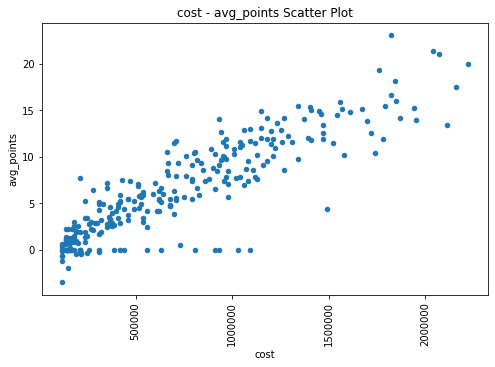

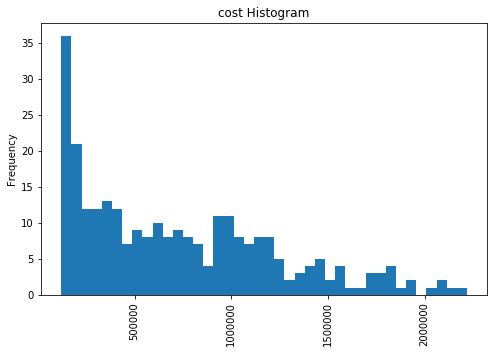

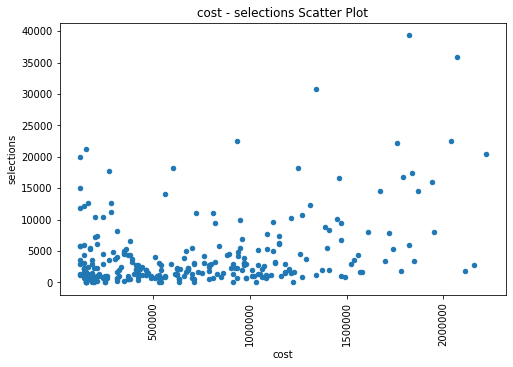

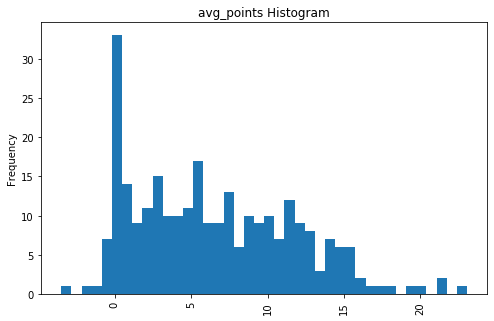

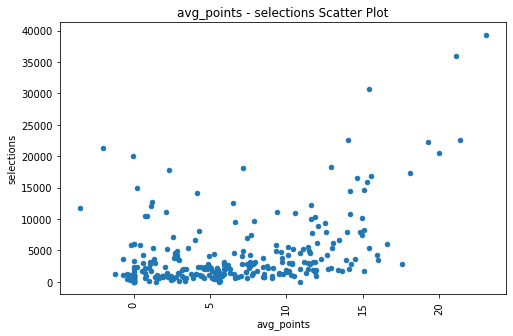

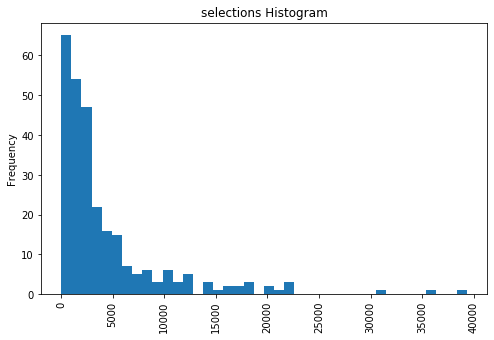

In [7]:
viz_cols = viz_df.columns.to_list()
combs = combinations(viz_cols, 2) 
  
for ind, comb in enumerate(combs): 
    x = comb[0]
    y = comb[1]
    
    # for each combination, scatter-plot the values
    viz_df.plot.scatter(x=x, y=y, figsize=(8,5),rot=90, title='{} - {} Scatter Plot'.format(x,y))
    
    # for each column, histogram-plot the values
    plt.figure()
    viz_df[viz_cols[ind]].plot.hist(figsize=(8,5),rot=90, title='{} Histogram'.format(viz_cols[ind]), bins=40)
    plt.show()

#### There is a linearity in between average score and cost values

### Read CSV File

In [8]:
csv_df = pd.read_csv('players_metadata.csv', delimiter='|')

In [9]:
csv_df.head()

,Player_Name,position,nationality
0,"ABALDE, ALBERTO",Forward,Spain
1,"ABASS, AWUDU",Guard,Italy
2,"ADAMS, JOSH",Guard,United States of America
3,"AGRAVANIS, DIMITRIS",Forward,Greece
4,"ANDERSON, JAMES",Guard,United States of America


### Merge CSV DataFrame with Extended JSON DataFrame

In [10]:
merged_df = pd.merge(ext_json_df, csv_df, on='Player_Name')
merged_df.head(1)

,Player_Name,cost,status,stats,positions,is_bye,locked,notes,avg_points,games_played,...,match_scores,owned_by,prices,round_rank,scores,season_rank,selections,total_points,position,nationality
0,"STRELNIEKS, JANIS",350000,playing,"{'scores': {'33': 3, '32': 8.8, '31': -2, '30'...",[2],0,0,{},7.15,33.0,...,"{'2017330251': 3, '2017320247': 8.8, '20173102...",5.0,"{'1': 1000000, '2': 970000, '3': 890000, '4': ...",59.0,"{'33': 3, '32': 8.8, '31': -2, '30': 6, '29': ...",116.0,4966.0,235.9,Guard,Latvia


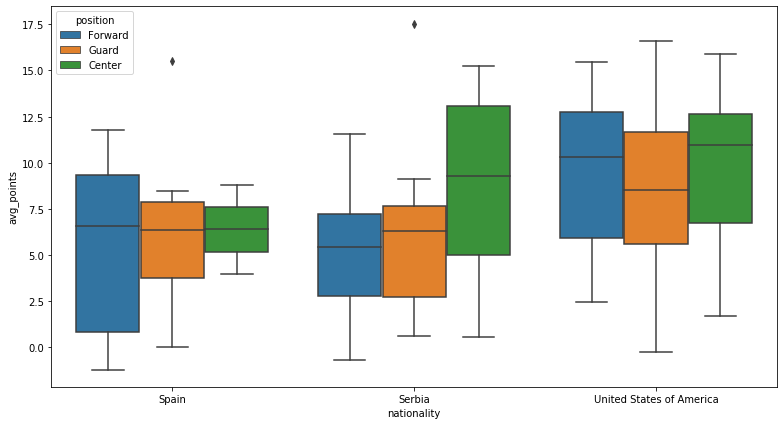

In [11]:
# get top 3 nationalities
top3_nats = list(merged_df.nationality.value_counts()[:3].index)

# define a DataFrame which includes players from top 3 nationalities
top3_df = merged_df[merged_df.nationality.isin(top3_nats)]

# boxplot the result
plt.figure(figsize=(13,7))
sns.boxplot(x='nationality',y='avg_points',hue='position',data=top3_df);

### Further examination

In [12]:
# number of players in each position by their nationality
top3_df.groupby('nationality').position.value_counts()

nationality               position
Serbia                    Guard        9
                          Forward      8
                          Center       7
Spain                     Forward     11
                          Guard        8
                          Center       2
United States of America  Guard       30
                          Forward     21
                          Center      16
Name: position, dtype: int64

In [13]:
# number of players in each position
top3_df.position.value_counts()

Guard      47
Forward    40
Center     25
Name: position, dtype: int64

### Extract Price Change and Current-Previous Scores

In [14]:
# a "messy" cell for extracting price, percentage price and score features

change_df = merged_df[['Player_Name', 'scores', 'prices']]
price_dic = {}
per_price_dic = {}
score_dic = {}
for ind in range(1, len(change_df)):
    keys = list(change_df.loc[ind]['scores'].keys())
    keys.reverse()
    temp_dic = {}
    temp_per_dic = {}
    temp_score_dic = {}
    for round_ in range(1, len(keys)):
        curr_score = change_df.loc[ind]['scores'][keys[round_]]
        player_name = change_df.loc[ind]['Player_Name']
        prev_price = change_df.loc[ind]['prices'][keys[round_-1]]
        curr_price = change_df.loc[ind]['prices'][keys[round_]
                                                 ]
        price_change = curr_price - prev_price
        percentage_price_change = round(100 * price_change / prev_price,3)
        temp_dic[round_] = price_change 
        temp_per_dic[round_] = percentage_price_change 
        temp_score_dic[round_] = curr_score
        
    price_dic[change_df.loc[ind]['Player_Name']] = temp_dic
    per_price_dic[change_df.loc[ind]['Player_Name']] = temp_per_dic
    score_dic[change_df.loc[ind]['Player_Name']] = temp_score_dic
price_df = pd.DataFrame(price_dic)
per_price_df = pd.DataFrame(per_price_dic)
score_df = pd.DataFrame(score_dic)


### Extract desired features in a DataFrame according to the current round

In [15]:
def extract_features(current_round, prev_rounds, dfs):
    price_df, per_price_df, score_df = dfs
    if current_round > prev_rounds:
        notna_ind = price_df.iloc[current_round].notna()
        per_price_change_array = np.expand_dims(per_price_df.iloc[current_round][notna_ind], axis=1)
        curr_score = np.expand_dims(score_df.iloc[current_round][notna_ind], axis=1)
        prev_scores = np.empty((per_price_change_array.shape[0], prev_rounds))
        column_dic = {0:'per_change', 1:'curr_score', 2:'round'}
        indx = price_df.columns[price_df.iloc[current_round].notna()]
        round_ = np.expand_dims(np.asarray([current_round]*curr_score.shape[0]),axis=1)
        for i in range(prev_rounds):
            prev_scores[:,i] = score_df.iloc[current_round-1-i][notna_ind]
            column_dic[i+3] = str(i + 1) +'_prev_score'
        feature_df = pd.DataFrame(columns=column_dic.values(), data=np.concatenate((per_price_change_array, curr_score, round_, prev_scores), axis=1), index=indx)
        return feature_df

### Visualize Correlation Matrix

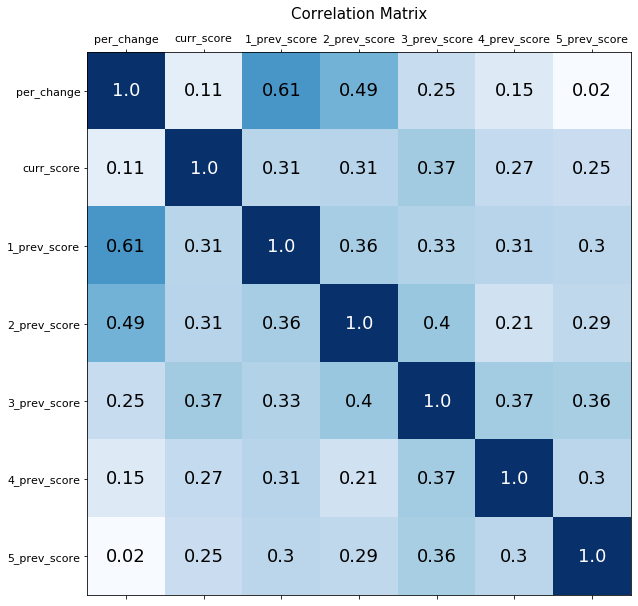

In [16]:
test_df = extract_features(6, 5, [price_df, per_price_df, score_df])
test_df = test_df.drop(columns='round')
column_dic = {i : test_df.columns.to_list()[i] for i in range(len(test_df.columns.to_list()))}
corr_matrix = test_df.corr()

plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.matshow(corr_matrix, cmap='Blues')
ax.set_title('Correlation Matrix', fontsize=15)
ax.set_xticklabels(['']+list(column_dic.values()), fontsize=11)
ax.set_yticklabels(['']+list(column_dic.values()), fontsize=11)

if corr_matrix.shape[0] < 10:
    for (i, j), z in np.ndenumerate(corr_matrix):
        if z > .75: 
            color = 'white'
        else:
            color = 'black'
        ax.text(j, i, '{}'.format(round(z,2)), ha='center', va='center', fontsize=18, color=color)

plt.show()

In [17]:
init_round = 9
prev_scores = 8
feature_df = extract_features(init_round, prev_scores, [price_df, per_price_df, score_df])

data_df = pd.DataFrame(columns=feature_df.columns)
for current_round in range(4,25):
    feature_df = extract_features(current_round, prev_scores, [price_df, per_price_df, score_df])    
    data_df = data_df.append(feature_df)



In [18]:
maxi = data_df['round'].max()
threshold = int(4*maxi/5)

train_df = data_df[data_df['round'] < threshold]
test_df = data_df[data_df['round'] >= threshold]

y_train  = train_df['per_change']
y_test   = test_df['per_change']

x_train = train_df.drop(columns=['curr_score', 'per_change'])
x_test = test_df.drop(columns=['curr_score', 'per_change'])

model = RandomForestRegressor(n_estimators=20, random_state=61)
model.fit(x_train, y_train)

test_preds = model.predict(x_test)
train_preds = model.predict(x_train)

test_error = mean_absolute_error(y_test, test_preds)
train_error = mean_absolute_error(y_train, train_preds)

In [20]:
test_error, train_error

(3.8750950372208437, 1.6279236086175943)